In [54]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import koreanize_matplotlib
from tensorflow.keras.utils import timeseries_dataset_from_array
import sys
sys.path.insert(1, '.')

In [55]:
import pandas as pd
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np

In [56]:
df1 = pd.read_pickle('./data/data2.pkl')
df1

측정소명,PM,영등포구,강서구,마포구,구로구
일시,,,,,
2021-01-01 00:00:00,13.0,12.0,13.0,11.0,8.0
2021-01-01 05:00:00,13.0,9.0,12.0,10.0,12.0
2021-01-01 06:00:00,17.0,12.0,13.0,13.0,10.0
2021-01-01 07:00:00,15.0,14.0,13.0,13.0,11.0
2021-01-01 08:00:00,16.0,14.0,16.0,17.0,11.0
...,...,...,...,...,...
2023-09-18 04:00:00,14.0,17.0,15.0,12.0,13.0
2023-09-18 05:00:00,13.0,13.0,12.0,14.0,13.0
2023-09-18 06:00:00,13.0,10.0,13.0,14.0,8.0


In [57]:
col_len = 5
col_order = list(range(1, col_len))
col_order.extend([0])
df1 = df1.iloc[:, col_order]
df1

측정소명,영등포구,강서구,마포구,구로구,PM
일시,,,,,
2021-01-01 00:00:00,12.0,13.0,11.0,8.0,13.0
2021-01-01 05:00:00,9.0,12.0,10.0,12.0,13.0
2021-01-01 06:00:00,12.0,13.0,13.0,10.0,17.0
2021-01-01 07:00:00,14.0,13.0,13.0,11.0,15.0
2021-01-01 08:00:00,14.0,16.0,17.0,11.0,16.0
...,...,...,...,...,...
2023-09-18 04:00:00,17.0,15.0,12.0,13.0,14.0
2023-09-18 05:00:00,13.0,12.0,14.0,13.0,13.0
2023-09-18 06:00:00,10.0,13.0,14.0,8.0,13.0


In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [59]:
df1

측정소명,영등포구,강서구,마포구,구로구,PM
일시,,,,,
2021-01-01 00:00:00,12.0,13.0,11.0,8.0,13.0
2021-01-01 05:00:00,9.0,12.0,10.0,12.0,13.0
2021-01-01 06:00:00,12.0,13.0,13.0,10.0,17.0
2021-01-01 07:00:00,14.0,13.0,13.0,11.0,15.0
2021-01-01 08:00:00,14.0,16.0,17.0,11.0,16.0
...,...,...,...,...,...
2023-09-18 04:00:00,17.0,15.0,12.0,13.0,14.0
2023-09-18 05:00:00,13.0,12.0,14.0,13.0,13.0
2023-09-18 06:00:00,10.0,13.0,14.0,8.0,13.0


In [60]:
df1.iloc[:,:-1].values, df1.iloc[:,[-1]].values

(array([[12., 13., 11.,  8.],
        [ 9., 12., 10., 12.],
        [12., 13., 13., 10.],
        ...,
        [10., 13., 14.,  8.],
        [ 9.,  6., 12.,  4.],
        [ 5.,  1., 10.,  2.]]),
 array([[13.],
        [13.],
        [17.],
        ...,
        [13.],
        [ 7.],
        [ 2.]]))

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:-1].values, df1.iloc[:,[-1]].values, test_size=0.2,shuffle=False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10808, 4) (10808, 1) (2702, 4) (2702, 1)


Convert the training data to tf.float32

In [62]:
scaled_X = scaler_X.fit_transform(X_train)
scaled_y = scaler_y.fit_transform(y_train)

data = tf.cast(scaled_X,tf.float32)
targets = tf.cast(scaled_y,tf.float32)

In [63]:
sample_len = 10
sequence_len = 1
batch_size = 256
input_len = 4

input_dataset = timeseries_dataset_from_array(data,None, sequence_length=sample_len,batch_size=batch_size, sequence_stride=sample_len)
target_dataset = timeseries_dataset_from_array(targets, None, sequence_length=sequence_len,batch_size=batch_size, sequence_stride=sample_len)

In [64]:
from tensorflow.keras.layers import GRU,LSTM,Dense,Input,TimeDistributed,RepeatVector
from tensorflow.keras.models import Model

in1 = Input((sample_len,input_len))
gru1 = GRU(128)(in1)
gru2 = RepeatVector(sequence_len)(gru1)
gru2 = GRU(128,return_sequences=True)(gru2)
gru2 = TimeDistributed(Dense(1))(gru2)

model1 = Model(in1,gru2)
model1.summary()

in2 = Input((sample_len,input_len))
lstm1 = LSTM(128)(in2)
lstm2 = RepeatVector(sequence_len)(lstm1)
lstm2 = LSTM(128,return_sequences=True)(lstm2)
lstm2 = TimeDistributed(Dense(1))(lstm2)

model2 = Model(in2, lstm2)
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 gru_4 (GRU)                 (None, 128)               51456     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 128)           0         
 or)                                                             
                                                                 
 gru_5 (GRU)                 (None, 1, 128)            99072     
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 1)             129       
 tributed)                                                       
                                                                 
Total params: 150,657
Trainable params: 150,657
Non-trainab

In [65]:
optimizer1 = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98,epsilon=1e-9)
optimizer2 = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98,epsilon=1e-9)

In [66]:
len_data = sum(1 for _ in input_dataset)

In [67]:
epoch = 500
for e in range(epoch):
    for i,batch in enumerate(zip(input_dataset, target_dataset)):

        if i<len_data-1:
            in1, tar = batch
            tar_inp = tf.ones((256,1,1))*-0.1
            tar_inp = tf.concat([tar_inp,tar[:, :-1]],axis=1)
            
            with tf.GradientTape() as tape:
                pred1 = model1(in1)
                loss = tf.reduce_mean(tf.square(tar-pred1))
            gradients1 = tape.gradient(loss, model1.trainable_variables)
            optimizer1.apply_gradients(zip(gradients1, model1.trainable_variables))
            
            with tf.GradientTape() as tape:
                pred2 = model2(in1)
                loss2 = tf.reduce_mean(tf.square(tar-pred2))
            gradients2 = tape.gradient(loss2, model2.trainable_variables)
            optimizer2.apply_gradients(zip(gradients2, model2.trainable_variables))
                
    print(f"epoch {e}| GRU:{loss.numpy()} | LSTM:{loss2.numpy()}")

epoch 0| GRU:0.007852284237742424 | LSTM:0.014871032908558846
epoch 1| GRU:0.010614651255309582 | LSTM:0.003711461089551449
epoch 2| GRU:0.00555285532027483 | LSTM:0.005777196027338505
epoch 3| GRU:0.006052919663488865 | LSTM:0.004034716635942459
epoch 4| GRU:0.005621195770800114 | LSTM:0.0045607732608914375
epoch 5| GRU:0.004916176199913025 | LSTM:0.0034705139696598053
epoch 6| GRU:0.005352886393666267 | LSTM:0.003716345876455307
epoch 7| GRU:0.004665713291615248 | LSTM:0.0030677104368805885
epoch 8| GRU:0.004633587319403887 | LSTM:0.0031133827287703753
epoch 9| GRU:0.004405776970088482 | LSTM:0.002808445133268833
epoch 10| GRU:0.0042808037251234055 | LSTM:0.0027008287142962217
epoch 11| GRU:0.004088465590029955 | LSTM:0.002538163447752595
epoch 12| GRU:0.003840483259409666 | LSTM:0.0025016542058438063
epoch 13| GRU:0.0035771748516708612 | LSTM:0.002320070518180728
epoch 14| GRU:0.00335756060667336 | LSTM:0.0021988151129335165
epoch 15| GRU:0.0030275220051407814 | LSTM:0.0020959358662

In [68]:
scaled_X = scaler_X.fit_transform(X_test)
x_test2 = timeseries_dataset_from_array(scaled_X, None, sequence_length=sample_len,batch_size=1, sequence_stride=sample_len)
y_test2 = timeseries_dataset_from_array(y_test, None, sequence_length=1,batch_size=1, sequence_stride=sample_len)
x_test2 = list(x_test2.as_numpy_iterator())
y_test2 = list(y_test2.as_numpy_iterator())

In [69]:
x_test3 = np.asarray(x_test2).reshape(-1,sample_len, input_len)
y_test3 = np.asarray(y_test2).reshape(-1,1,1)

In [70]:
pred_gru = model1(x_test3)
pred_gru = scaler_y.inverse_transform(np.array(pred_gru).reshape(-1, 1))
err_gru = np.mean((pred_gru-y_test3)**2)
err_gru = np.mean([(y_true-y_pred)**2 for y_true,y_pred in zip(y_test3,pred_gru)])

pred_lstm = model2(x_test3)
pred_lstm = scaler_y.inverse_transform(np.array(pred_lstm).reshape(-1, 1))
# err_lstm = np.mean((pred_lstm-y_test3[:-1])**2)
err_lstm = np.mean([(y_true-y_pred)**2 for y_true,y_pred in zip(y_test3,pred_lstm)])

err_gru, err_lstm

(24.70971816093163, 29.715275830706627)

In [71]:
def plot(data, y_predict_test):
    plt.plot(data[:, [-1]].flatten(), label='실제 PM2.5')

    plt.plot(y_predict_test.flatten(), label='Test 데이터 예측 PM2.5')

    plt.legend()
    plt.show()

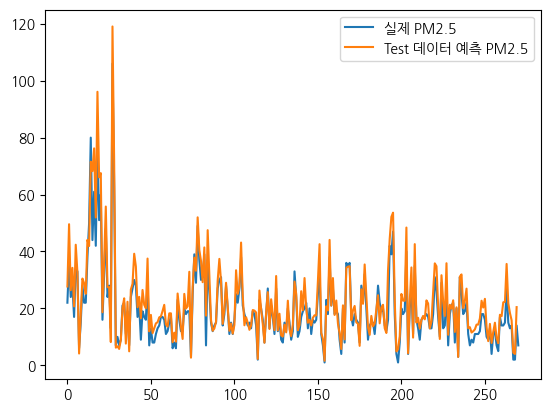

In [72]:
plot(y_test3,pred_gru)

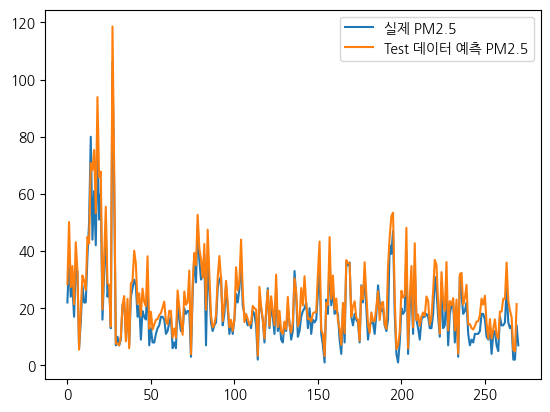

In [73]:
plot(y_test3,pred_lstm)